In [1]:
import os
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as ex
import seaborn as sns
from pydantic import BaseModel, Field
from tqdm.notebook import tqdm

from desdeo_tools.utilities.fast_non_dominated_sorting import non_dominated

from functools import partial

In [9]:
def plotly_animate(reference_data, found_solutions, colormap):
    methods = [
        "DSS",
        "DSS Pruned",
        "Random",
        "Random Pruned",
    ]
    reference_data["method"] = "reference"
    for method in methods:
        found_solutions[method]["method"] = method

    num_rows = found_solutions[methods[0]].shape[0]
    num_frames = 5

    tall_data = pd.DataFrame()
    for i in range(num_frames):
        end_idx = (i + 1) * num_rows // num_frames
        temp_data = reference_data
        temp_data["iteration"] = end_idx
        tall_data = pd.concat([tall_data, temp_data])

    num_rows = 500
    for method, df in found_solutions.items():
        for i in range(num_frames):
            end_idx = (i + 1) * num_rows // num_frames
            end_idx = min(end_idx, df.shape[0])
            temp_data = df.iloc[:end_idx]
            temp_data["iteration"] = (i + 1) * 100
            tall_data = pd.concat([tall_data, temp_data])

    fig = ex.scatter_3d(
        tall_data,
        x="f1",
        y="f2",
        z="f3",
        color="method",
        color_discrete_map=colormap,
        animation_frame="iteration",
        range_x=[0, 1],
        range_y=[0, 1],
        range_z=[0, 1],
    )

    # make marker line width 0
    for i, trace in enumerate(fig.data):
        trace.marker.line.width = 0
        # set opacity to 1
        trace.opacity = 1
        trace.marker.size = 10
        # set opacity of reference points to 0.5
        if trace.name == "reference":
            trace.opacity = 0.3
            trace.marker.size = 5
    return fig

In [3]:
class OneExperimentResults(BaseModel):
    problemName: str = Field(description="Name of the problem")
    method: str = Field(description="Name of the method")
    runID: int = Field(description="Run number")
    hv: list[float] = Field(description="Hypervolume (Normalized) of the found solutions at each iteration")
    IDG: list[float] = Field("IGD of the found solutions at each iteration")
    RSE: list[float | None] = Field("ln(RSE) of the found solutions at each iteration")
    uniformity: list[float | None] = Field("Uniformity Level of the found solutions at each iteration")
    coverage: list[float] = Field("Coverage Error of the found solutions at each iteration")
    spacing: list[float | None] = Field("Spacing indicator value of the found solutions at each iteration")
    CumBadRefs: list[float] = Field(description="Cumulative fraction of bad reference points found at each iteration")
    success: list[bool] = Field(description="Whether the method evaluated a valid reference point at each iteration")
    runtime: float = Field(description="Runtime of the experiment")
    found_solutions: list[list[float]] = Field(description="Found solutions at each iteration")


class ExperimentResults(BaseModel):
    results: list[OneExperimentResults] = Field(description="Results of the experiment")

In [4]:
def get_data(problem_name):
    data = pd.read_csv(f"../data/{problem_name}")
    ideal = np.zeros(data.shape[1])
    nadir = np.ones(data.shape[1])
    return data.to_numpy(), ideal, nadir, data.shape[1]


problems = {
    "dtlz5_3": partial(get_data, "dtlz5_3.csv"),
    "dtlz5_4": partial(get_data, "dtlz5_4.csv"),
    "dtlz5_5": partial(get_data, "dtlz5_5.csv"),
    "dtlz7": partial(get_data, "dtlz7.csv"),
    "forest1": partial(get_data, "forest_Carb.csv"),
    "forest2": partial(get_data, "forest_DW.csv"),
    "forest3": partial(get_data, "forest_HA.csv"),
    "forest4": partial(get_data, "forest_Rev.csv"),
    "nforest1": partial(get_data, "nforest_Carb.csv"),
    "nforest2": partial(get_data, "nforest_DW.csv"),
    "nforest3": partial(get_data, "nforest_HA.csv"),
    "forest": partial(get_data, "forest.csv"),
    "nforest": partial(get_data, "nforest.csv"),
    "RE31": partial(get_data, "RE31.csv"),
    "RE32": partial(get_data, "RE32.csv"),
    "RE33": partial(get_data, "RE33.csv"),
    "RE34": partial(get_data, "RE34.csv"),
    "RE35": partial(get_data, "RE35.csv"),
    "RE36": partial(get_data, "RE36.csv"),
    "RE37": partial(get_data, "RE37.csv"),
    "RE41": partial(get_data, "RE41.csv"),
    "RE42": partial(get_data, "RE42.csv"),
    "RE61": partial(get_data, "RE61.csv"),
}

In [10]:
root = "../results/"
problem = list(problems.keys())[0]
# list all files in the directory

files = os.listdir(root)
files = [f for f in files if problem in f]

# read all the files
f_results = []
for f in files:
    with open(root + f, "r") as file:
        data = file.read()
        temp = OneExperimentResults.model_validate_json(data)
        if temp.problemName == problem:
            f_results.append(temp)

In [11]:
# 3 Objective forest results

methods = list(set([r.method for r in f_results]))
runIDs = list(set([r.runID for r in f_results]))

f_pd = pd.DataFrame(
    columns=[
        "method",
        "runID",
        "iteration",
        "HV",
        "IGD",
        "uniformity",
        "coverage",
        "spacing",
        "RSE" "Bad Reference Points Found",
        "success",
        "runtime",
    ]
)
found_solutions = {}

for r in f_results:
    # print lenghts
    to_add = pd.DataFrame(
        {
            "method": [r.method] * len(r.CumBadRefs),
            "runID": [r.runID] * len(r.CumBadRefs),
            "iteration": range(len(r.CumBadRefs)),
            "HV": r.hv + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "IGD": r.IDG + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "spacing": r.spacing + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "uniformity": r.uniformity,
            "coverage": r.coverage,
            "RSE": r.RSE + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "Bad Reference Points Found": r.CumBadRefs,
            "success": np.array(r.success).astype(int),
            "runtime": [r.runtime] * len(r.CumBadRefs),
        }
    )
    f_pd = pd.concat([f_pd, to_add])
    if r.runID == 1:
        found_solutions[r.method] = pd.DataFrame(
            r.found_solutions,
            columns=[f"f{i+1}" for i in range(len(r.found_solutions[0]))],
        )

reference_data = problems[problem]()[0]

reference_data = (reference_data - reference_data.min()) / (reference_data.max() - reference_data.min())

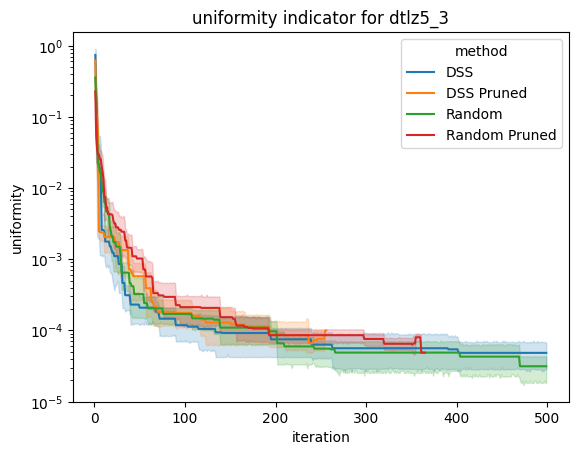

In [12]:
f, ax = plt.subplots()
ax.set()
metric = "uniformity"
f_pd_clean = f_pd[[metric, "iteration", "method"]].dropna()
sns.lineplot(data=f_pd_clean.sort_values("method"), y=metric, x="iteration", hue="method")

# Set y-axis limits
# ax.set_ylim(10, 11)
ax.set_title(f"{metric} indicator for {problem}")
# log scale for y-axis
ax.set_yscale("log")

In [53]:
f_pd_clean.groupby(["method"])["iteration"].max()

method
DSS              499
DSS Pruned       240
Random           499
Random Pruned    348
Name: iteration, dtype: int64

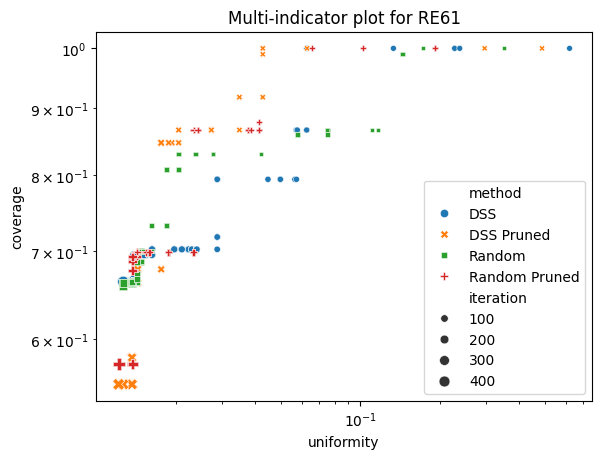

In [146]:
f, ax = plt.subplots()
ax.set()
metric = "uniformity"
f_pd_clean = f_pd[["coverage", "uniformity", "iteration", "method"]].dropna()

f_pd_clean = f_pd_clean.groupby(["method", "iteration"]).median().reset_index()
sns.scatterplot(
    data=f_pd_clean.sort_values("method"),
    y="coverage",
    x="uniformity",
    size="iteration",
    hue="method",
    style="method",
    ax=ax,
)

# Set y-axis limits
# ax.set_ylim(10, 11)
ax.set_title(f"Multi-indicator plot for {problem}")
# log scale for y-axis
ax.set_yscale("log")
ax.set_xscale("log")

In [19]:
# If a method is not present for all iterations, fill the missing iterations with the last value
test = (
    f_pd[["coverage", "uniformity", "iteration", "method", "runID"]]
    .dropna()
    .pivot(index="iteration", columns=["method", "runID"], values=["coverage", "uniformity"])
)
test = test.fillna(method="ffill")
test = test.fillna(method="bfill")


test = pd.melt(test.reset_index(), id_vars="iteration")
test["metric"] = test[None]
test = test.drop(columns=[None])
test
# convert test to wide format by splitting metric column into two columns
test = test.pivot(index=["iteration", "method", "runID"], columns="metric", values="value").reset_index()
test = test.groupby(["method", "iteration"]).median().reset_index()
test

/tmp/bssainix/3544282/ipykernel_1492239/972218849.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test = f_pd[["coverage", "uniformity", "iteration", "method", "runID"]].dropna().pivot(index="iteration", columns=["method", "runID"], values=["coverage", "uniformity"])
/tmp/bssainix/3544282/ipykernel_1492239/972218849.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test = f_pd[["coverage", "uniformity", "iteration", "method", "runID"]].dropna().pivot(index="iteration", columns=["method", "runID"], values=["coverage", "uniformity"])


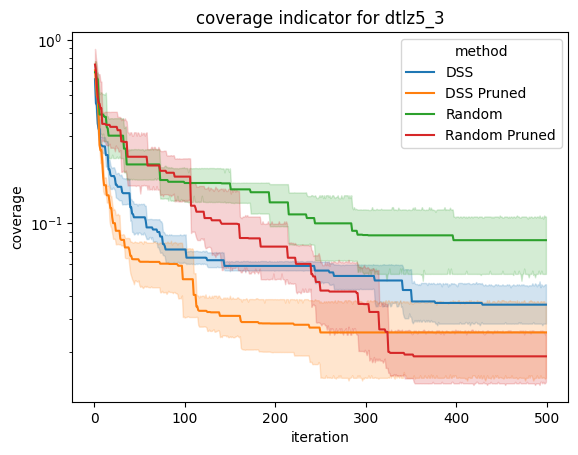

In [23]:
f, ax = plt.subplots()
ax.set()
metric = "coverage"
sns.lineplot(data=test.sort_values("method"), y=metric, x="iteration", hue="method", ax=ax)

# Set y-axis limits
# ax.set_ylim(10, 11)
ax.set_title(f"{metric} indicator for {problem}")
# log scale for y-axis
ax.set_yscale("log")

In [151]:
fig = ex.scatter(
    test,
    x="coverage",
    y="uniformity",
    animation_frame="iteration",
    animation_group="method",
    color="method",
    log_y=True,
    log_x=True,
    opacity=0.5,
    range_x=[0.9 * f_pd_clean["coverage"].min(), 1.1 * f_pd_clean["coverage"].max()],
    range_y=[0.9 * f_pd_clean["uniformity"].min(), 1.1 * f_pd_clean["uniformity"].max()],
)
fig
# make the figure cube
# fig.update_layout(scene=dict(aspectmode="cube"))

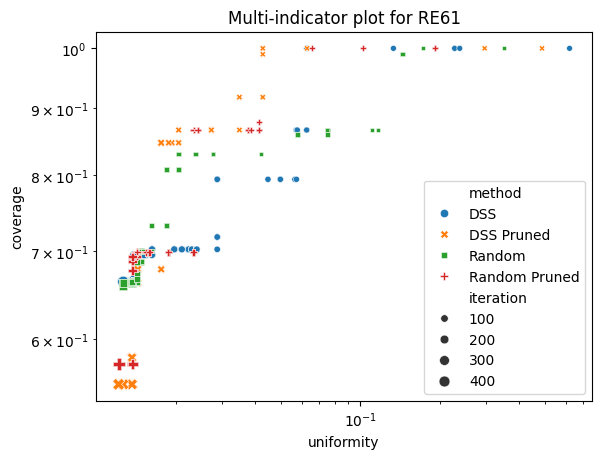

In [153]:
f, ax = plt.subplots()
ax.set()

sns.scatterplot(
    data=test.sort_values("method"), y="coverage", x="uniformity", size="iteration", hue="method", style="method", ax=ax
)

# Set y-axis limits
# ax.set_ylim(10, 11)
ax.set_title(f"Multi-indicator plot for {problem}")
# log scale for y-axis
ax.set_yscale("log")
ax.set_xscale("log")

(0.0021362110911571624, 0.1)

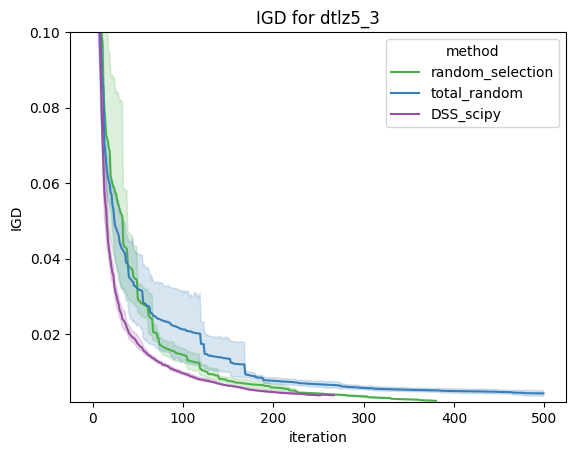

In [6]:
f, ax = plt.subplots()
# ax.set(yscale="log", xscale="log")
colormap = {
    "reference": "#e41a1c",
    "total_random": "#377eb8",
    "random_selection": "#4daf4a",
    "DSS_scipy": "#984ea3",
}

f_pd = f_pd[["IGD", "iteration", "method"]].dropna()
sns.lineplot(data=f_pd, x="iteration", y="IGD", hue="method", palette=colormap)
ax.set_title(f"IGD for {problem}")
ax.set_ylim(0.9 * f_pd["IGD"].min(), 0.1)

# f.savefig(f"igd_{problem}.png")

In [19]:
def auto_plot(inputs):
    problem, data_reader = inputs
    reference_data = data_reader()[0]
    reference_data = pd.DataFrame(reference_data, columns=[f"f{i+1}" for i in range(reference_data.shape[1])])

    colormap = {
        "DSS": "#e41a1c",
        "DSS Pruned": "#377eb8",
        "Random": "#4daf4a",
        "Random Pruned": "#984ea3",
        "reference": "gray",
    }

    root = "../results/"
    # list all files in the directory

    

    files = os.listdir(root)
    files = [f for f in files if problem in f]

    # read all the files
    f_results = []
    for f in files:
        with open(root + f, "r") as file:
            data = file.read()
            temp = OneExperimentResults.model_validate_json(data)
            if temp.problemName == problem:
                f_results.append(temp)

    f_pd = pd.DataFrame(
        columns=[
            "method",
            "runID",
            "iteration",
            "IGD",
            "uniformity",
            "coverage",
        ]
    )

    found_solutions = {}

    for r in f_results:
        to_add = pd.DataFrame(
            {
                "method": [r.method] * len(r.CumBadRefs),
                "runID": [r.runID] * len(r.CumBadRefs),
                "iteration": range(len(r.CumBadRefs)),
                "IGD": r.IDG + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "uniformity": r.uniformity,
                "coverage": r.coverage,
            }
        )
        f_pd = pd.concat([f_pd, to_add])
        if r.runID == 1:
            found_solutions[r.method] = pd.DataFrame(
                r.found_solutions,
                columns=[f"f{i+1}" for i in range(len(r.found_solutions[0]))],
            )

    # Animation
    # Only do this for 3D problems
    if reference_data.shape[1] == 3:
        fig = plotly_animate(reference_data, found_solutions, colormap)
        fig.write_html(f"../figures/{problem}_animation.html")

    f_pd_clean = (
        f_pd[["coverage", "uniformity", "IGD", "iteration", "method", "runID"]]
        .dropna()
        .pivot(index="iteration", columns=["method", "runID"], values=["coverage", "uniformity", "IGD"])
    )
    f_pd_clean = f_pd_clean.fillna(method="ffill")
    f_pd_clean = f_pd_clean.fillna(method="bfill")

    f_pd_clean = pd.melt(f_pd_clean.reset_index(), id_vars="iteration")
    f_pd_clean["metric"] = f_pd_clean[None]
    f_pd_clean = f_pd_clean.drop(columns=[None])
    # convert test to wide format by splitting metric column into two columns
    f_pd_clean = f_pd_clean.pivot(
        index=["iteration", "method", "runID"], columns="metric", values="value"
    ).reset_index()

    # Alternate names
    indicators = {
        "IGD": "IGD Indicator",
        "uniformity": "Uniformity Level",
        "coverage": "Coverage Error",
    }

    # Individual plots
    for indicator in indicators.keys():
        f, ax = plt.subplots()
        ax.set()
        sns.lineplot(data=f_pd_clean.sort_values("method"), y=indicator, x="iteration", hue="method", palette=colormap)
        ax.set_title(f"{indicator} indicator for {problem}")
        if indicator != "IGD":
            ax.set_yscale("log")
        else:
            ax.set_ylim(0.9 * f_pd_clean[indicator].min(), 0.1)
        ax.set_title(f"{indicators[indicator]} for {problem}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel(indicators[indicator])
        f.savefig(f"../figures/{indicator}_{problem}.png")

    f_pd_clean = f_pd_clean.groupby(["method", "iteration"]).median().reset_index()

    # Multi-indicator plot
    f, ax = plt.subplots()
    ax.set()
    sns.scatterplot(
        data=f_pd_clean.sort_values("method"),
        y="coverage",
        x="uniformity",
        size="iteration",
        hue="method",
        style="method",
        palette=colormap,
        ax=ax,
    )
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(f"Multi-indicator plot for {problem}")
    ax.set_xlabel("Uniformity Level")
    ax.set_ylabel("Coverage Error")
    f.savefig(f"../figures/multi_indicator_{problem}.png")

In [20]:
all_figs_opts = []
for problem, data_reader in problems.items():
    all_figs_opts.append((problem, data_reader))

In [21]:
results = []
with Pool(len(os.sched_getaffinity(0))) as p:
    max_exp = len(all_figs_opts)
    with tqdm(total=max_exp) as pbar:
        for i, result in enumerate(p.imap_unordered(auto_plot, all_figs_opts)):
            pbar.update()

  0%|          | 0/23 [00:00<?, ?it/s]

/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/bssainix/3544282/ipykernel_1566126/555345951.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [24]:
methods = ["DSS_scipy", "random_selection", "total_random"]
RSE_results = pd.DataFrame(columns=["method", "problem", "RSE"])

for result in results.results:
    method = result.method
    problem = result.problemName
    RSE = result.RSE[-1]
    RSE_results = pd.concat([RSE_results, pd.DataFrame({"method": method, "problem": problem, "RSE": RSE}, index=[0])])

<Axes: xlabel='problem', ylabel='RSE'>

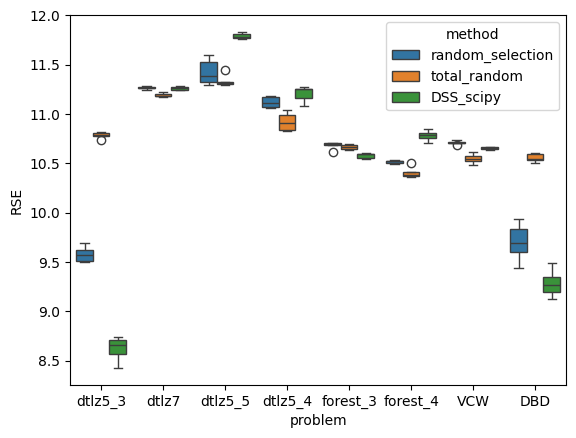

In [25]:
sns.boxplot(data=RSE_results, x="problem", y="RSE", hue="method")

In [30]:
RSE_results.groupby(["problem"], group_keys=True)["RSE"].apply(lambda x: x - x.min()).reset_index()

,problem,level_1,RSE
0,DBD,0,0.812278
1,DBD,0,0.702254
2,DBD,0,0.563676
3,DBD,0,0.309826
4,DBD,0,0.474329
...,...,...,...
115,forest_4,0,0.492310
116,forest_4,0,0.351344
117,forest_4,0,0.397440
118,forest_4,0,0.430423


<Axes: xlabel='iteration', ylabel='1-HV'>

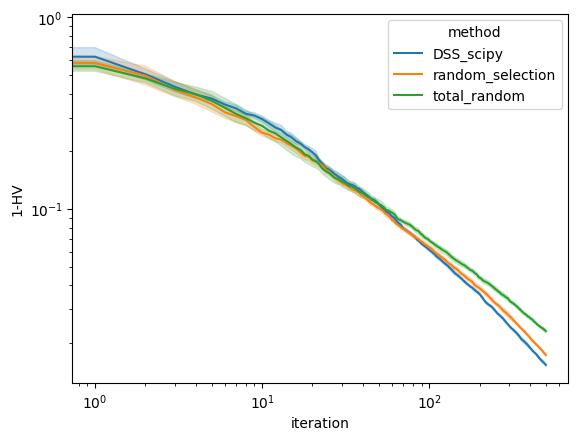

In [30]:
f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
f_pd["1-HV"] = 1 - f_pd["HV"]
sns.lineplot(data=f_pd, x="iteration", y="1-HV", hue="method")

# f.savefig(f"hv_{problem}.png")

In [5]:
rolling = pd.DataFrame(columns=["method", "runID", "iteration", "success"])

In [6]:
ids = f_pd["runID"].unique()
methods = f_pd["method"].unique()

for method in methods:
    for runID in ids:
        r = f_pd[(f_pd["method"] == method) & (f_pd["runID"] == runID)]
        rolling = pd.concat(
            [
                rolling,
                pd.DataFrame(
                    {
                        "method": [method] * len(r),
                        "runID": [runID] * len(r),
                        "iteration": r["iteration"],
                        "success": r["success"].cumsum(),
                    }
                ),
            ]
        )
rolling = rolling.dropna()

<Axes: xlabel='iteration', ylabel='success'>

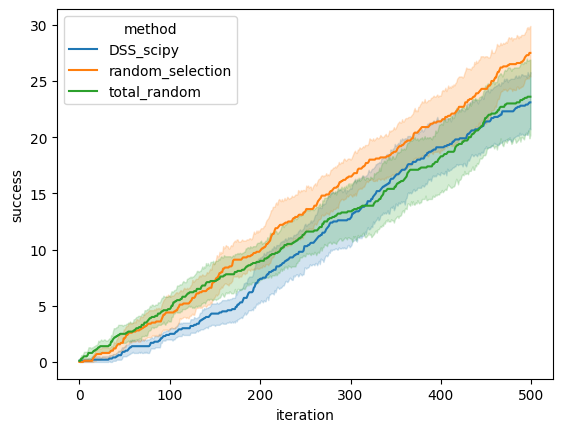

In [7]:
f, ax = plt.subplots()
sns.lineplot(data=rolling, x="iteration", y="Cumulative success", hue="method")
# f.savefig(f"success_{problem}.png")

<Axes: xlabel='iteration', ylabel='Bad Reference Points Found'>

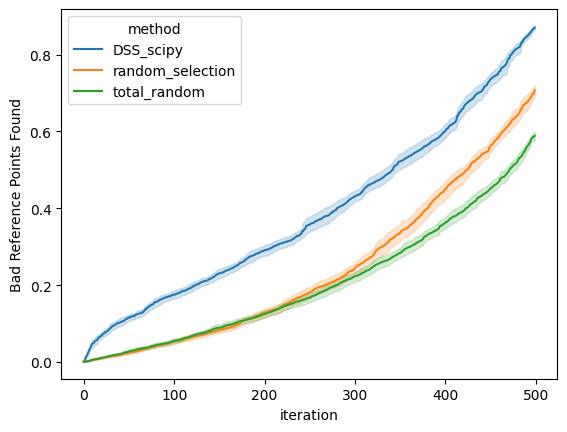

In [34]:
f, ax = plt.subplots()
sns.lineplot(data=f_pd, x="iteration", y="Bad Reference Points Found", hue="method")
# f.savefig(f"bad_ref_found_{problem}.png")